In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("D:/Github/note/module")                        # for windows
# sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from glob import glob
from get_info_TWSE import GetInfoTWSE
from get_info_FinMind import GetInfoFinMind
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.sandwich_covariance import cov_hac
from linearmodels.panel import FamaMacBeth
from pprint import pprint

# get data

In [2]:
list = pd.read_csv("stock_id_list.csv")
list = list["Code"].to_list()

In [3]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

TWSE_fetcher = GetInfoTWSE(certify = False)
FinMind_fetcher = GetInfoFinMind(cerify = False)
files = glob("data\\*.csv")

stock_price_failed_lt = []
margin_info_complete_lt = []
margin_info_failed_lt = []
holding_info_complete_lt = []
holding_info_failed_lt = []

In [4]:
for id in tqdm(list):
    try:
        df = TWSE_fetcher.init_df(str(id), "2020-01-01", "2025-09-04")
        df = TWSE_fetcher.get_stock_price()
        df = TWSE_fetcher.get_day_trading_info()
        df = df[df["不能做空當沖"] != "Y"]
        df.to_csv(f"data2/{id}.csv", index = True)
    except:
        stock_price_failed_lt.append(id)
        continue

  1%|▏         | 15/1066 [1:06:44<79:17:26, 271.60s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  px = pd.concat(all_data, ignore_index = True)
  2%|▏         | 17/1066 [1:16:07<80:11:18, 275.19s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  px = pd.concat(all_data, ignore_index = True)
  2%|▏         | 18/1066 [1:20:21<78:14:39, 268.78s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning: The 

錯誤：unsupported operand type(s) for /: 'float' and 'str'


 67%|██████▋   | 716/1066 [46:38:46<24:17:20, 249.83s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  px = pd.concat(all_data, ignore_index = True)
 67%|██████▋   | 717/1066 [46:41:31<21:45:10, 224.38s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  px = pd.concat(all_data, ignore_index = True)
 68%|██████▊   | 728/1066 [47:42:45<51:55:52, 553.11s/it]D:\Github/note/module\get_info_TWSE.py:189: FutureWarning

In [ ]:
"""merge margin info"""

for f in files:
    stock_id = f.split("\\")[-1].replace(".csv", "")
    base_df = pd.read_csv(f, index_col = "Date")
    try:
        if stock_id in margin_info_complete_lt:
            continue
        
        start_time = base_df.index[0]
        end_time = base_df.index[-1]

        if base_df.empty:
            print(f"{stock_id} is empty")
            continue

        df = FinMind_fetcher.init_df(stock_id, start_time, end_time)
        df = FinMind_fetcher.get_margin_info()
        base_df = base_df.join(df, how = "left")
        base_df.to_csv(f"data/{stock_id}.csv")
        margin_info_complete_lt.append(stock_id)

    except Exception as e:
        margin_info_failed_lt.append(stock_id)
        print(e)
        continue

2025-09-12 22:58:16.607 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1101
2025-09-12 22:58:17.076 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1101B
2025-09-12 22:58:17.250 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1102
2025-09-12 22:58:17.767 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1103
2025-09-12 22:58:18.255 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1104
2025-09-12 22:58:18.678 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_id: 1108
2025-09-12 22:58:18.958 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockMarginPurchaseShortSale, data_

In [55]:
"""get holding structure per"""

for f in files:
    # read and clean data
    stock_id = f.split("\\")[-1].replace(".csv", "")
    base_df = pd.read_csv(f, index_col = "Date")
    base_df.index = pd.to_datetime(base_df.index, format = "%Y-%m-%d")

    try:
        base_df.drop(columns = ["10~50張", "10~50張.1","10~50張.2","10~50張.3","10~50張.4"], inplace = True)
    except:
        pass

    try:
        if stock_id in holding_info_complete_lt:
            continue

        start_time = base_df.index[0].strftime("%Y-%m-%d")
        end_time = base_df.index[-1].strftime("%Y-%m-%d")
        if base_df.empty:
            print(f"{stock_id} is empty")
            continue
        
        df = FinMind_fetcher.init_df(stock_id, start_time, end_time)
        df = FinMind_fetcher.get_share_holding()
        df = FinMind_fetcher.get_stock_holding_share_per()

        base_df.index = pd.to_datetime(base_df.index, format = "%Y-%m-%d")
        df.index = pd.to_datetime(df.index, format = "%Y-%m-%d")
        
        # drop 重複 cols
        cols_to_drop = list(set(base_df.columns).intersection(set(df.columns)))
        if cols_to_drop: # 檢查列表是否為空
            base_df.drop(columns = cols_to_drop, errors = "ignore", inplace = True)
            base_df = base_df.join(df, how = "left")

        base_df.to_csv(f"data/{stock_id}.csv")
        holding_info_complete_lt.append(stock_id)

    except Exception as e:
        holding_info_failed_lt.append(stock_id)
        print(e)
        continue

2025-09-15 09:32:26.065 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 4571
2025-09-15 09:32:26.598 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 4571
2025-09-15 09:32:27.259 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 4572
2025-09-15 09:32:27.662 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 4572
2025-09-15 09:32:28.339 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 4576
2025-09-15 09:32:28.801 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 4576
2025-09-15 09:32:29.480 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 4581
2025-09-15 09:32:29.730 | INFO     | FinMind.data.finmind

index 0 is out of bounds for axis 0 with size 0


2025-09-15 09:36:37.710 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 8011
2025-09-15 09:36:38.206 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 8016
2025-09-15 09:36:38.646 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 8016
2025-09-15 09:36:39.526 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 8021
2025-09-15 09:36:39.997 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 8021
2025-09-15 09:36:40.878 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockShareholding, data_id: 8028
2025-09-15 09:36:41.410 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanStockHoldingSharesPer, data_id: 8028
2025-09-15 09:36:41.983 | INFO     | FinMind.data.fin

# Analyse

## function

In [11]:
def get_c_o_ret(df: pd.DataFrame) -> pd.DataFrame:
    df["c_o_ret"] = (df["Close"] - df["Open"]) / df["Open"] # 建立 (Close - Open) / Open
    df["c_o_ret_t+1"] = df["c_o_ret"].shift(-1)
    mean = df["c_o_ret_t+1"].mean()
    df["demeaned_ret_t+1"] = df["c_o_ret_t+1"] - mean
    
    return df

In [12]:
def sorted_plot(
    ratio_sorted_df: pd.DataFrame,
    x: str,
    ly: str,
    max_ly: bool = False,
    ry: str | None = None,
    point_ry: float | None = None,      # 右軸：以「數值」找最近點
    point_ly: float | None = None,      # 左軸：以「數值」找最近點；也可用 "max"/"min"
    point_ly_pct: float | None = None,  # 左軸：以「樣本比例」(0~1 或 0~100) 指定位置
):
    # ---------- 防呆 ----------
    if len(ratio_sorted_df) == 0:
        return {}
    if ly not in ratio_sorted_df.columns:
        raise KeyError(f"{ly} not in DataFrame columns")
    if ry is not None and ry not in ratio_sorted_df.columns:
        raise KeyError(f"{ry} not in DataFrame columns")

    # ---------- 字型（避免中文缺字警告） ----------
    try:
        plt.rcParams['font.family'] = 'Microsoft JhengHei'  # Windows
        matplotlib.rcParams['axes.unicode_minus'] = False
    except Exception:
        pass

    # ---------- x 座標 ----------
    if x == "index":
        x_vals = pd.Series(
            np.arange(len(ratio_sorted_df), dtype=float) / max(len(ratio_sorted_df), 1),
            index=ratio_sorted_df.index,
            name="x"
        )
        x_label = "sample proportion"
    else:
        x_vals = ratio_sorted_df[x]
        x_label = x
        # 若 x 不是數值，仍可畫，但無法顯示百分比
        # 若你想一律畫比例，可改：x_vals = np.arange(len(df))/len(df)

    fig, ax1 = plt.subplots(figsize=(16, 5))

    # ---------- 左軸 ----------
    y_left = ratio_sorted_df[ly].astype(float)
    ax1.plot(x_vals, y_left, label=ly, color="tab:blue")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ly, color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    marks = {"ly_max": None, "ly_point": None, "ry_point": None}

    # (A) 標記 ly 最大值
    if max_ly and len(y_left) > 0:
        max_pos = int(y_left.values.argmax())
        max_idx = y_left.index[max_pos]
        max_x = x_vals.loc[max_idx]
        max_y = y_left.loc[max_idx]
        percent = float(max_x) * 100 if np.issubdtype(type(max_x), np.number) else np.nan

        ax1.scatter(max_x, max_y, color="black", zorder=5)
        ax1.axvline(max_x, color="gray", linestyle="--", linewidth=1)
        ax1.annotate(
            f"{ly} max\nidx={max_idx}\ny={max_y:.4f}" + (f"\n({percent:.1f}%)" if np.isfinite(percent) else ""),
            xy=(max_x, max_y),
            xytext=(max_x, max_y + (y_left.abs().max() * 0.05 or 1.0)),
            ha="center",
            fontsize=9, color="black"
        )
        marks["ly_max"] = {
            "index": max_idx,
            "rank": max_pos + 1,
            "proportion": float(max_pos / len(y_left)),
            "x": float(max_x) if np.issubdtype(type(max_x), np.number) else None,
            "y": float(max_y)
        }

    # (B) 標記 ly 的指定點（數值 or 百分比 or "max"/"min"）
    if point_ly is not None or point_ly_pct is not None:
        if isinstance(point_ly, str):
            if point_ly.lower() == "max":
                pos = int(y_left.values.argmax())
            elif point_ly.lower() == "min":
                pos = int(y_left.values.argmin())
            else:
                raise ValueError('point_ly as string must be "max" or "min"')
        elif point_ly_pct is not None:
            pct = float(point_ly_pct)
            if pct > 1:
                pct /= 100.0
            pct = min(max(pct, 0.0), 1.0)
            pos = int(round(pct * (len(ratio_sorted_df) - 1)))
        else:
            # 用數值找最近
            pos = int((y_left - float(point_ly)).abs().values.argmin())

        ly_idx = y_left.index[pos]
        px = x_vals.loc[ly_idx]
        py = y_left.loc[ly_idx]
        percent = float(pos / len(y_left) * 100.0)

        ax1.scatter(px, py, color="tab:blue", zorder=6)
        ax1.axvline(px, color="tab:blue", linestyle="--", linewidth=1)
        ax1.annotate(
            f"{ly}\nidx={ly_idx}\ny={py:.4f}\n({percent:.1f}%)",
            xy=(px, py),
            xytext=(px, py + (y_left.abs().max() * 0.05 or 1.0)),
            ha="center",
            fontsize=9, color="tab:blue"
        )
        marks["ly_point"] = {
            "index": ly_idx,
            "rank": pos + 1,
            "proportion": float(pos / len(y_left)),
            "x": float(px) if np.issubdtype(type(px), np.number) else None,
            "y": float(py)
        }

    # ---------- 右軸 ----------
    ax2 = None
    if ry:
        y_right = ratio_sorted_df[ry].astype(float)
        ax2 = ax1.twinx()
        ax2.plot(x_vals, y_right, label=ry, color="tab:red", linestyle="--")
        ax2.set_ylabel(ry, color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        if point_ry is not None and len(y_right) > 0:
            pos = int((y_right - float(point_ry)).abs().values.argmin())
            idx_closest = y_right.index[pos]
            px = x_vals.loc[idx_closest]
            py = y_right.loc[idx_closest]
            percent = float(pos / len(y_right) * 100.0)

            ax2.scatter(px, py, color="red", zorder=6)
            ax2.axvline(px, color="red", linestyle="--", linewidth=1)
            ax2.annotate(
                f"{ry}\nidx={idx_closest}\ny={py:.4f}\n({percent:.1f}%)",
                xy=(px, py),
                xytext=(px, py + (y_right.abs().max() * 0.05 or 0.01)),
                ha="center",
                fontsize=9, color="red"
            )
            marks["ry_point"] = {
                "index": idx_closest,
                "rank": pos + 1,
                "proportion": float(pos / len(y_right)),
                "x": float(px) if np.issubdtype(type(px), np.number) else None,
                "y": float(py)
            }

    # ---------- 圖例 ----------
    lines, labels = ax1.get_legend_handles_labels()
    if ax2 is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc = "center left", bbox_to_anchor=(1.05, 0.5))
    else:
        ax1.legend(loc = "best")
    total_samples = len(ratio_sorted_df)
    fig.text(0.98, 0.01, f"Samples: {total_samples}", ha = 'right', fontsize = 12, color = "b")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return marks

In [13]:
def group(
    df: pd.DataFrame,
    col: str,
    point1: float = 0.2,
    point2: float | None = None
) -> tuple:
    """
    對指定欄位進行分組統計與 t 檢驗，回傳分組資料與報告表。
    
    若未指定 point2，則分為兩組：
    - Group1: 0 ~ point1
    - Group2: point1 ~ 1

    若指定 point2，則分為三組：
    - Group1: 0 ~ point1
    - Group2: point1 ~ point2
    - Group3: point2 ~ 1
    """
    n = len(df)
    cut1 = int(n * point1)

    if point2 is None:
        df1 = df.iloc[:cut1]
        df2 = df.iloc[cut1:]
        g1 = df1[col].dropna()
        g2 = df2[col].dropna()

        group_stats = {
            "mean": [g1.mean(), g2.mean()],
            "std": [g1.std(), g2.std()],
            "count": [len(g1), len(g2)],
            "missing": [
                df.iloc[:cut1][col].isna().sum(),
                df.iloc[cut1:][col].isna().sum()
            ]
        }
        group_stats_df = pd.DataFrame(group_stats, index=["Group1 (0~{:.0%})".format(point1), "Group2 ({:.0%}~100%)".format(point1)])

        ttest_df = pd.DataFrame({
            "comparison": ["g1 vs g2"],
            "t-stat": [stats.ttest_ind(g1, g2, equal_var = False).statistic],
            "p-value": [stats.ttest_ind(g1, g2, equal_var = False).pvalue]
        })

        print(group_stats_df, "\n", ttest_df)
        return df1, df2

    else:
        cut2 = int(n * point2)
        df1 = df.iloc[:cut1]
        df2 = df.iloc[cut1:cut2]
        df3 = df.iloc[cut2:]
        g1 = df1[col].dropna()
        g2 = df2[col].dropna()
        g3 = df3[col].dropna()

        group_stats = {
            "mean": [g1.mean(), g2.mean(), g3.mean()],
            "std": [g1.std(), g2.std(), g3.std()],
            "count": [len(g1), len(g2), len(g3)],
            "missing": [
                df.iloc[:cut1][col].isna().sum(),
                df.iloc[cut1:cut2][col].isna().sum(),
                df.iloc[cut2:][col].isna().sum()
            ]
        }
        group_stats_df = pd.DataFrame(group_stats, index=[
            "Group1 (0~{:.0%})".format(point1),
            "Group2 ({:.0%}~{:.0%})".format(point1, point2),
            "Group3 ({:.0%}~100%)".format(point2)
        ])

        ttest_df = pd.DataFrame({
            "comparison": ["g1 vs g2", "g2 vs g3", "g1 vs g3"],
            "t-stat": [
                stats.ttest_ind(g1, g2, equal_var=False).statistic,
                stats.ttest_ind(g2, g3, equal_var=False).statistic,
                stats.ttest_ind(g1, g3, equal_var=False).statistic
            ],
            "p-value": [
                stats.ttest_ind(g1, g2, equal_var=False).pvalue,
                stats.ttest_ind(g2, g3, equal_var=False).pvalue,
                stats.ttest_ind(g1, g3, equal_var=False).pvalue
            ]
        })

        print(group_stats_df, "\n", ttest_df)
        return df1, df2, df3

## 看資料傾向

In [33]:
"""concat 成 panel data and sort"""

files = glob("data\\*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    if df.empty:
        print(f"{stock_id} is empty")
        continue
    df["stock"] = stock_id
    df = get_c_o_ret(df)
    dfs.append(df)

panel_df = pd.concat(dfs, ignore_index = True)

panel_df.dropna(subset = ["當日沖銷交易成交股數", "demeaned_ret_t+1", "10~50張.5", "10~50張.6", "10~50張.7", "10~50張.8"], inplace = True)
panel_df

7765 is empty


,Date,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,...,100~200張,200~400張,400~600張,600~800張,800~1000張,1000張以上,stock,c_o_ret,c_o_ret_t+1,demeaned_ret_t+1
0,2020-01-02,43.80,44.15,43.80,44.10,18470566.0,1947000.0,85694250.0,85731050.0,0.105411,...,3.09,2.96,1.77,1.39,1.15,74.09,1101,0.006849,-0.004530,-0.003941
1,2020-01-03,44.15,44.25,43.45,43.95,18387114.0,1479000.0,64845450.0,65006000.0,0.080437,...,3.09,2.96,1.77,1.39,1.15,74.09,1101,-0.004530,-0.001149,-0.000561
2,2020-01-06,43.50,43.70,43.30,43.45,13867625.0,1400000.0,60872150.0,60804000.0,0.100955,...,3.05,2.90,1.73,1.39,1.11,74.45,1101,-0.001149,0.003452,0.004041
3,2020-01-07,43.45,43.60,43.20,43.60,14185347.0,1100000.0,47762900.0,47814400.0,0.077545,...,3.05,2.90,1.73,1.39,1.11,74.45,1101,0.003452,0.005794,0.006382
4,2020-01-08,43.15,43.55,43.15,43.40,13465670.0,1047000.0,45354050.0,45412500.0,0.077753,...,3.05,2.90,1.73,1.39,1.11,74.45,1101,0.005794,0.001152,0.001741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89821,2025-08-25,16.10,16.20,15.95,16.15,822288.0,201000.0,3228850.0,3236650.0,0.244440,...,3.48,2.98,1.56,1.00,0.70,68.50,1434,0.003106,-0.003115,-0.002759
89822,2025-08-26,16.05,16.25,15.95,16.00,2084984.0,460000.0,7389150.0,7403500.0,0.220625,...,3.48,2.98,1.56,1.00,0.70,68.50,1434,-0.003115,-0.003115,-0.002759
89823,2025-08-27,16.05,16.20,16.00,16.00,1041629.0,353000.0,5686800.0,5685650.0,0.338892,...,3.48,2.98,1.56,1.00,0.70,68.50,1434,-0.003115,-0.012500,-0.012143
89824,2025-08-28,16.00,16.00,15.80,15.80,1350630.0,200000.0,3176300.0,3181400.0,0.148079,...,3.48,2.98,1.56,1.00,0.70,68.50,1434,-0.012500,-0.009434,-0.009077


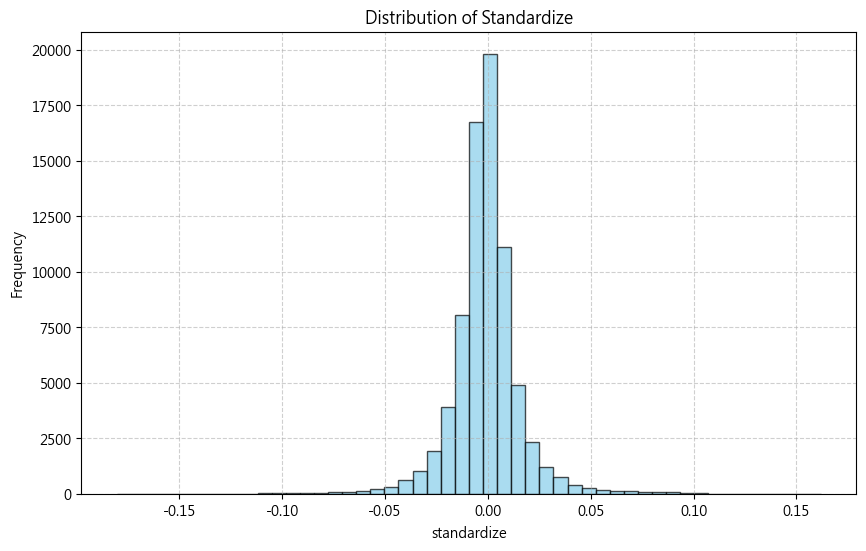

In [58]:
plt.figure(figsize = (10, 6))
plt.hist(panel_df["c_o_ret"].dropna(), bins = 50, color = "skyblue", edgecolor = "black", alpha = 0.7)
plt.title("Distribution of Standardize")
plt.xlabel("standardize")
plt.ylabel("Frequency")
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.show()

### day_trading ratio sorted

#### first sort: day_trading ratio

In [15]:
ratio_sorted_df = panel_df.sort_values("當沖佔交易量比例").reset_index(drop = True)
ratio_sorted_df.reset_index(drop = True, inplace = True)
ratio_sorted_df = ratio_sorted_df.loc[: 1149120]

# cumsum ret
ratio_sorted_df["cum_c_o_ret_t+1"] = ratio_sorted_df["c_o_ret_t+1"].cumsum()
ratio_sorted_df["cum_demeaned_ret_t+1"] = ratio_sorted_df["demeaned_ret_t+1"].cumsum()

# print
ratio_sorted_df.to_csv("ratio_sorted_df.csv")
ratio_sorted_df

,Date,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,...,400~600張,600~800張,800~1000張,1000張以上,stock,c_o_ret,c_o_ret_t+1,demeaned_ret_t+1,cum_c_o_ret_t+1,cum_demeaned_ret_t+1
0,2023-05-05,50.3,50.3,50.0,50.20,143651.0,0.0,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,6184,-0.001988,-0.001992,-0.002120,-0.001992,-0.002120
1,2023-04-06,50.1,50.3,50.1,50.20,8174.0,0.0,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,6184,0.001996,-0.007874,-0.008002,-0.009866,-0.010122
2,2023-03-31,50.2,50.3,50.2,50.30,24060.0,0.0,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,6184,0.001992,0.001996,0.001868,-0.007870,-0.008254
3,2021-11-11,74.9,74.9,74.4,74.40,9569.0,0.0,0.000000e+00,0.000000e+00,0.000000,...,2.17,2.43,4.50,59.89,3617,-0.006676,-0.005413,-0.004038,-0.013283,-0.012292
4,2023-04-27,50.1,50.5,50.0,50.00,110082.0,0.0,0.000000e+00,0.000000e+00,0.000000,...,NaN,NaN,NaN,NaN,6184,-0.001996,0.001996,0.001868,-0.011287,-0.010424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149116,2021-11-22,46.0,49.2,45.9,46.90,5104773.0,2608000.0,1.246618e+08,1.250208e+08,0.510894,...,NaN,NaN,NaN,NaN,8271,0.019565,-0.024468,-0.022040,-1574.980465,21.471247
1149117,2021-11-22,1180.0,1195.0,1140.0,1145.00,1395590.0,713000.0,8.267250e+08,8.303900e+08,0.510895,...,10.14,9.33,8.82,33.92,3661,-0.029661,-0.034632,-0.032449,-1575.015097,21.438797
1149118,2024-02-29,36.8,37.4,36.7,36.85,117440.0,60000.0,2.219550e+06,2.218050e+06,0.510899,...,2.33,2.45,4.34,63.83,1410,0.001359,0.006803,0.006068,-1575.008295,21.444865
1149119,2023-08-08,76.0,77.3,75.1,75.10,41104.0,21000.0,1.590600e+06,1.593600e+06,0.510899,...,NaN,NaN,NaN,NaN,6504,-0.011842,0.017426,0.020951,-1574.990868,21.465817


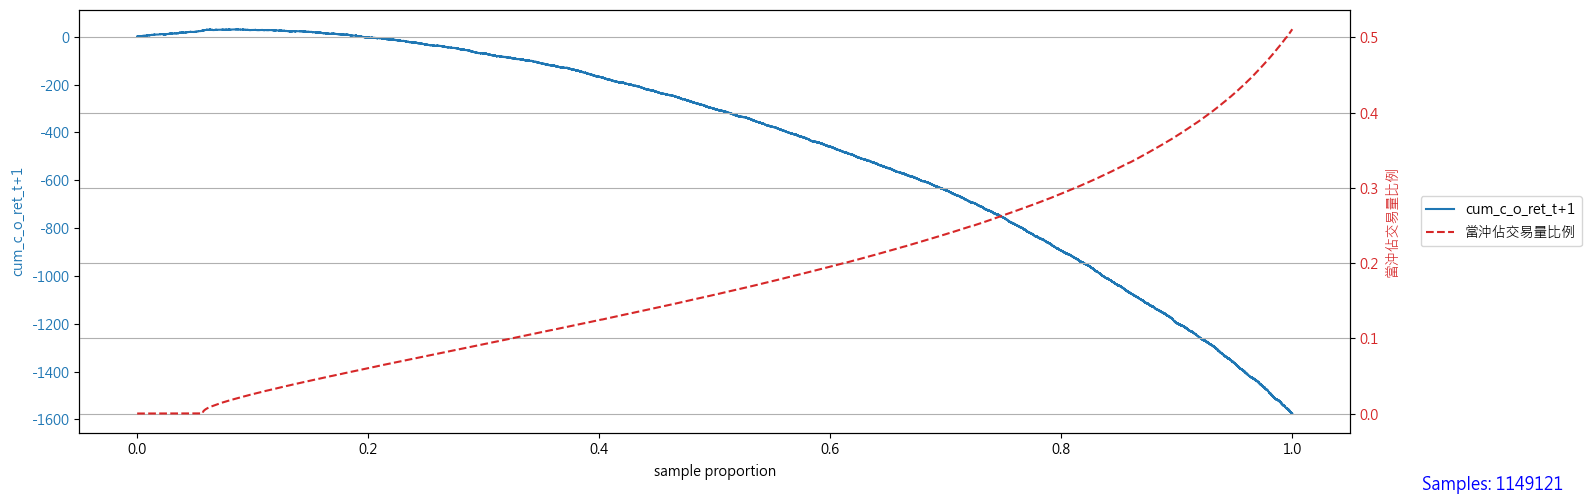

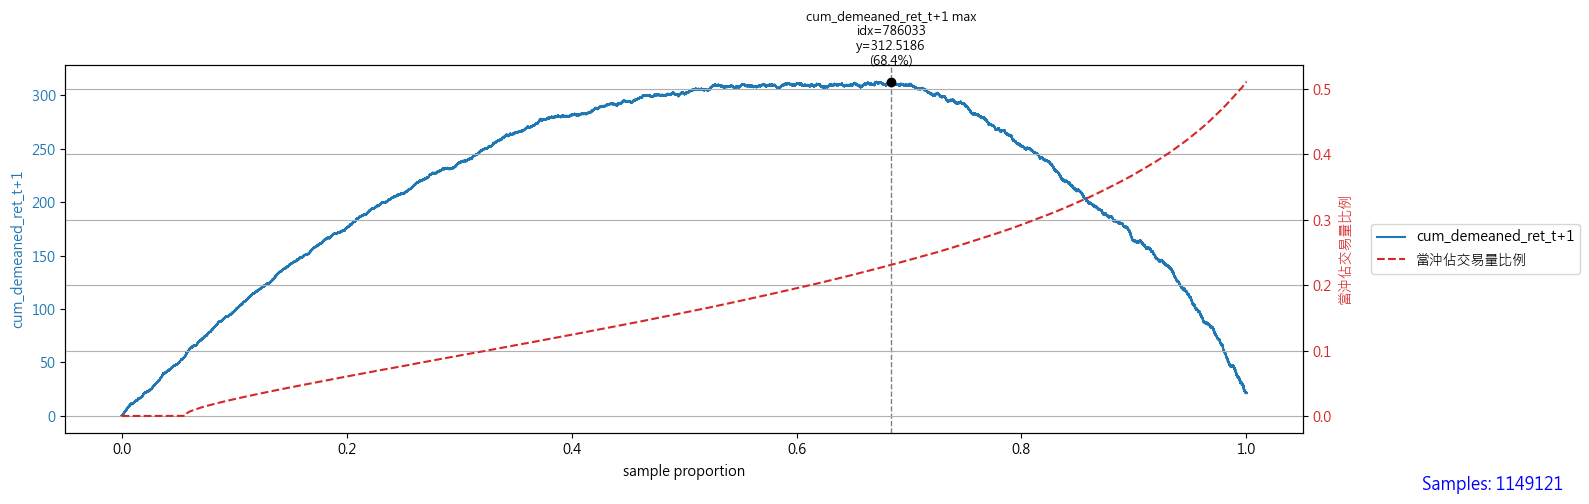

{'ly_max': {'index': 786033,
  'rank': 786034,
  'proportion': 0.6840297932071557,
  'x': 0.6840297932071557,
  'y': 312.5185735695795},
 'ly_point': None,
 'ry_point': None}

In [23]:
sorted_plot(ratio_sorted_df, "index", "cum_c_o_ret_t+1", max_ly = False, ry = "當沖佔交易量比例")
sorted_plot(ratio_sorted_df, "index", "cum_demeaned_ret_t+1", max_ly = True, ry = "當沖佔交易量比例")

In [24]:
"""maximization 右邊樣本的 demeaned mean"""
right_df = ratio_sorted_df.loc[786033: ]
right_mean = right_df["demeaned_ret_t+1"].mean()
print(right_mean)

-0.0008018461276507551


In [25]:
"""全樣本分組"""
g11, g12 = group(ratio_sorted_df, "當沖佔交易量比例")

results1 = {}
group_names_1 = ["g11", "g12"]
groups1 = [g11, g12]

for name, g in zip(group_names_1, groups1):
    X = sm.add_constant(g[["當沖佔交易量比例"]])
    Y = g["demeaned_ret_t+1"]
    print(f"{name} cleaned size:", len(X))
    print(f"{name} coef mean:", X["當沖佔交易量比例"].mean())
    print(f"{name} Y mean:", Y.mean())
    res = sm.OLS(Y, X).fit()
    results1[name] = res
# print(results1["g12"].summary())

                       mean       std   count  missing
Group1 (0~20%)     0.025225  0.020563  229824        0
Group2 (20%~100%)  0.217549  0.112967  919297        0 
   comparison      t-stat  p-value
0   g1 vs g2 -1533.85207      0.0
g11 cleaned size: 229824
g11 coef mean: 0.025224905596992635
g11 Y mean: 0.0007637624343866102
g12 cleaned size: 919297
g12 coef mean: 0.21754854807752547
g12 Y mean: -0.000167696371255476


In [28]:
"""right_df's regression"""
X = sm.add_constant(right_df["當沖佔交易量比例"])
Y = right_df["demeaned_ret_t+1"]
res = sm.OLS(Y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       demeaned_ret_t+1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     89.10
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           3.77e-21
Time:                        09:59:16   Log-Likelihood:             8.2663e+05
No. Observations:              363088   AIC:                        -1.653e+06
Df Residuals:                  363086   BIC:                        -1.653e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      4.918      0.0

#### second sort: 價格級距

In [40]:
price_ratio_sorted_df = ratio_sorted_df.sort_values("Close").reset_index(True)
price_ratio_sorted_df

IndexError: Too many levels: Index has only 1 level, not 2

### 上影線 sorted

#### function

In [16]:
def get_upper_shadow(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    no_upper = (df["High"] - np.maximum(df["Open"], df["Close"])) == 0

    # 計算上影線
    df["Upper_shadow_ratio_per"] = np.where(
        ~no_upper,
        ((df["High"] / np.maximum(df["Open"], df["Close"])) - 1) * 100,
        np.nan
    )

    return df

#### execute

In [19]:
panel_df.dropna(subset = "當日沖銷交易成交股數", inplace = True)
shadow_sorted_df = get_upper_shadow(panel_df)
shadow_sorted_df

,Date,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,...,200~400張,400~600張,600~800張,800~1000張,1000張以上,stock,c_o_ret,c_o_ret_t+1,demeaned_ret_t+1,Upper_shadow_ratio_per
0,2020-01-02,43.80,44.15,43.80,44.10,18470566.0,1947000.0,85694250.0,85731050.0,0.105411,...,2.96,1.77,1.39,1.15,74.09,1101,0.006849,-0.004530,-0.003941,0.113379
1,2020-01-03,44.15,44.25,43.45,43.95,18387114.0,1479000.0,64845450.0,65006000.0,0.080437,...,2.96,1.77,1.39,1.15,74.09,1101,-0.004530,-0.001149,-0.000561,0.226501
2,2020-01-06,43.50,43.70,43.30,43.45,13867625.0,1400000.0,60872150.0,60804000.0,0.100955,...,2.90,1.73,1.39,1.11,74.45,1101,-0.001149,0.003452,0.004041,0.459770
3,2020-01-07,43.45,43.60,43.20,43.60,14185347.0,1100000.0,47762900.0,47814400.0,0.077545,...,2.90,1.73,1.39,1.11,74.45,1101,0.003452,0.005794,0.006382,NaN
4,2020-01-08,43.15,43.55,43.15,43.40,13465670.0,1047000.0,45354050.0,45412500.0,0.077753,...,2.90,1.73,1.39,1.11,74.45,1101,0.005794,0.001152,0.001741,0.345622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366982,2025-08-28,191.50,192.00,187.50,188.00,1598643.0,554000.0,105070500.0,104815000.0,0.346544,...,NaN,NaN,NaN,NaN,NaN,9958,-0.018277,-0.034211,-0.031808,0.261097
1366983,2025-08-29,190.00,190.00,182.00,183.50,4036605.0,1162000.0,214361000.0,214851000.0,0.287866,...,NaN,NaN,NaN,NaN,NaN,9958,-0.034211,-0.029973,-0.027570,NaN
1366984,2025-09-01,183.50,185.00,175.00,178.00,3488965.0,1055000.0,188959000.0,189448500.0,0.302382,...,NaN,NaN,NaN,NaN,NaN,9958,-0.029973,-0.014006,-0.011603,0.817439
1366985,2025-09-02,178.50,179.50,175.00,176.00,2021527.0,836000.0,147687000.0,147980000.0,0.413549,...,NaN,NaN,NaN,NaN,NaN,9958,-0.014006,-0.019830,-0.017428,0.560224


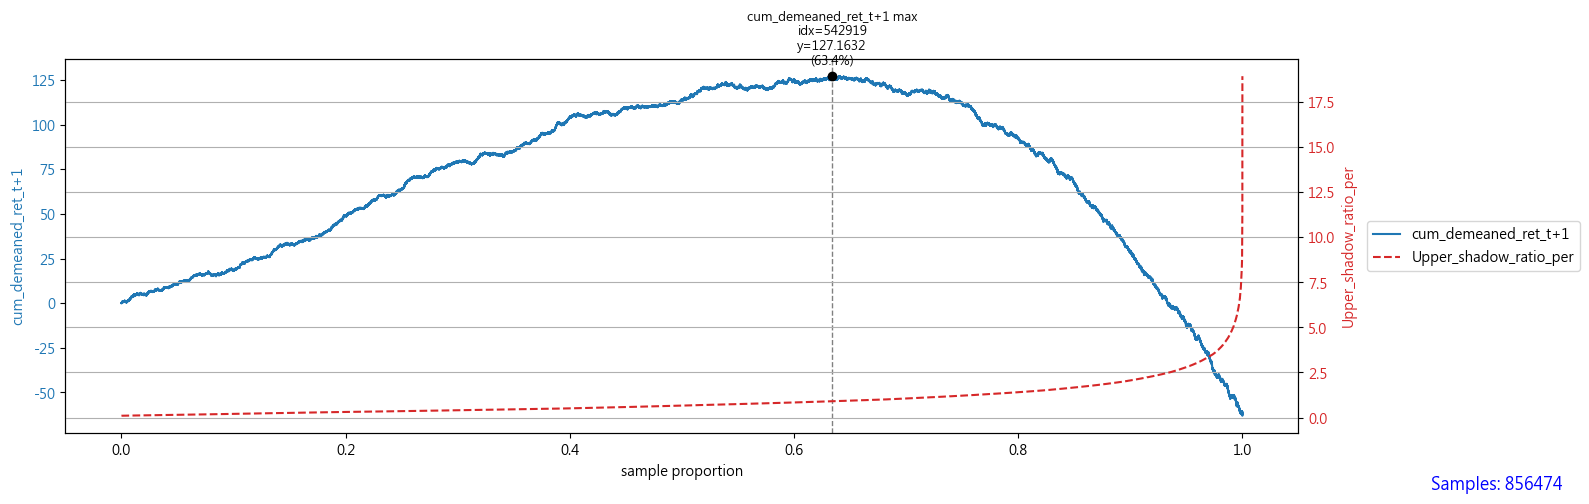

-0.00033315801725045547


In [20]:
"""sort by second factor"""
# 直接drop掉較合理 不然要考慮所有沒有上影線的情況太多了
shadow_sorted_df = shadow_sorted_df.sort_values("Upper_shadow_ratio_per").reset_index(drop = True)
shadow_sorted_df.dropna(subset = "Upper_shadow_ratio_per", inplace = True)

shadow_sorted_df["cum_demeaned_ret_t+1"] = shadow_sorted_df["demeaned_ret_t+1"].cumsum()
sorted_plot(shadow_sorted_df[: ], "index", ly = "cum_demeaned_ret_t+1", ry = "Upper_shadow_ratio_per", max_ly = True) # point 0.99: 847908
print(shadow_sorted_df["demeaned_ret_t+1"].iloc[348735: ].mean())

### Day trading ratio + Upper shadow

In [21]:
ratio_upper_sorted_df = get_upper_shadow(panel_df)
ratio_upper_sorted_df = ratio_upper_sorted_df.sort_values(["當日沖銷交易成交股數", "Upper_shadow_ratio_per"]).reset_index(drop = True)
ratio_upper_sorted_df = ratio_upper_sorted_df.iloc[: 1149120]
ratio_upper_sorted_df.dropna(subset = "Upper_shadow_ratio_per", inplace = True)

ratio_upper_sorted_df["cum_demeaned_ret_t+1"] = ratio_upper_sorted_df["demeaned_ret_t+1"].cumsum()
ratio_upper_sorted_df

,Date,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,當沖佔交易量比例,...,400~600張,600~800張,800~1000張,1000張以上,stock,c_o_ret,c_o_ret_t+1,demeaned_ret_t+1,Upper_shadow_ratio_per,cum_demeaned_ret_t+1
0,2024-04-30,49.50,50.00,49.50,49.95,11395.0,0.0,0.0,0.0,0.000000,...,2.43,1.45,1.12,85.74,1203,0.009091,0.000000,-0.001953,0.100100,-0.001953
1,2021-02-23,49.90,50.00,49.80,49.95,10013.0,0.0,0.0,0.0,0.000000,...,5.48,11.68,4.55,28.86,2496,0.001002,0.000000,0.000063,0.100100,-0.001890
2,2022-02-07,49.30,50.00,49.30,49.95,16016.0,0.0,0.0,0.0,0.000000,...,5.75,8.03,5.12,28.16,2496,0.013185,0.014141,0.014205,0.100100,0.012315
3,2022-11-21,49.95,50.00,49.90,49.95,8000.0,0.0,0.0,0.0,0.000000,...,2.63,0.00,2.49,65.17,3528,0.000000,0.001002,0.001939,0.100100,0.014255
4,2022-11-22,49.90,50.00,49.70,49.95,18088.0,0.0,0.0,0.0,0.000000,...,2.63,0.00,2.49,65.17,3528,0.001002,-0.006000,-0.005063,0.100100,0.009192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149115,2021-05-12,104.50,106.00,94.00,97.70,11112119.0,5451000.0,541951600.0,544967700.0,0.490546,...,NaN,NaN,NaN,NaN,6505,-0.065072,-0.035533,-0.035236,1.435407,38.511534
1149116,2021-07-21,75.50,76.70,73.50,74.00,10521188.0,5451000.0,408360000.0,408791200.0,0.518097,...,2.56,1.16,0.82,75.50,2368,-0.019868,0.001325,0.002441,1.589404,38.513975
1149117,2024-10-18,38.70,40.70,38.20,40.05,9075082.0,5451000.0,216507600.0,217146750.0,0.600656,...,1.95,1.60,2.79,53.61,1727,0.034884,0.002460,0.004414,1.622971,38.518390
1149118,2025-02-07,25.25,25.95,25.00,25.05,10913574.0,5451000.0,138815700.0,138662950.0,0.499470,...,2.56,1.56,0.39,37.22,4142,-0.007921,-0.041667,-0.036658,2.772277,38.481732


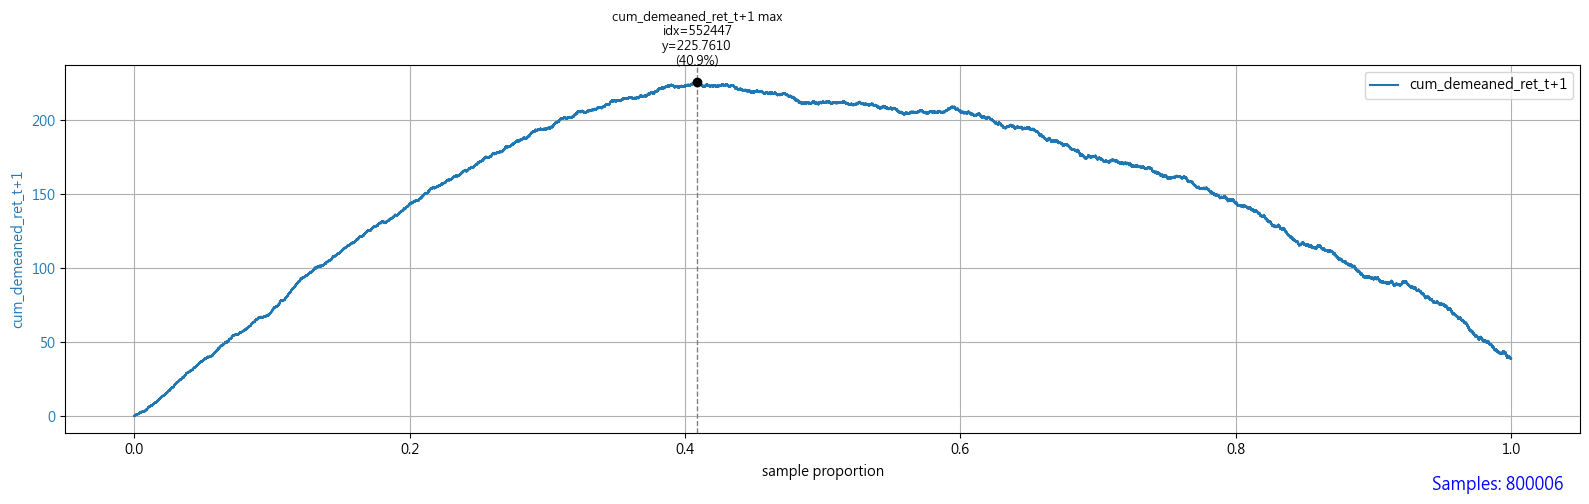

0.00031515846251138326
-0.0005478041181638189


In [22]:
sorted_plot(ratio_upper_sorted_df, "index", "cum_demeaned_ret_t+1", max_ly = True)
left_df = ratio_upper_sorted_df.iloc[: 552447]
right_df = ratio_upper_sorted_df.iloc[552447: ]
left_mean = left_df["demeaned_ret_t+1"].mean()
right_mean = right_df["demeaned_ret_t+1"].mean()
print(left_mean)
print(right_mean)

<Axes: xlabel='Upper_shadow_ratio_per', ylabel='demeaned_ret_t+1'>

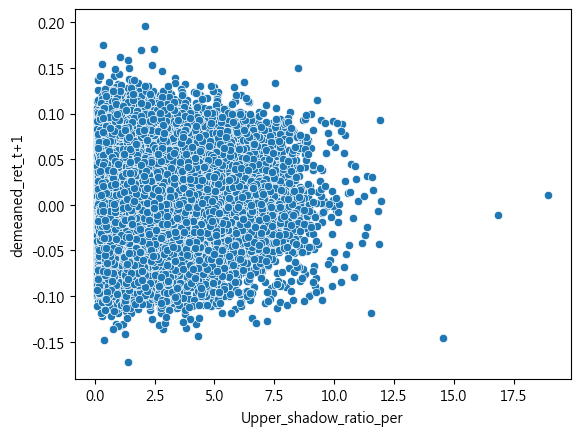

In [ ]:
"""test the factor"""
sns.scatterplot(x = "Upper_shadow_ratio_per", y = "demeaned_ret_t+1", data = ratio_upper_sorted_df)
X = sm.add_constant(ratio_upper_sorted_df["Upper_shadow_ratio_per"])
Y = ratio_upper_sorted_df["demeaned_ret_t+1"]

model = sm.OLS(Y, X).fit()
print(model.summary())

### BiasNorm sorted

In [26]:
bias_sorted_df = panel_df.sort_values("當沖佔交易量比例").reset_index(drop = True)
bias_sorted_df.reset_index(drop = True, inplace = True)
bias_sorted_df.drop(index = bias_sorted_df.index[1149120: ], inplace = True)
bias_sorted_df = bias_sorted_df.sort_values("BiasNorm").reset_index(drop = True)

# 把 'stock' 移到第二個位置
cols = bias_sorted_df.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
bias_sorted_df = bias_sorted_df[cols]

# 累加 ret
bias_sorted_df["cum_c_o_ret_t+1"] = bias_sorted_df["c_o_ret_t+1"].cumsum()
mean = bias_sorted_df["c_o_ret_t+1"].mean()
bias_sorted_df["standardize"] = bias_sorted_df["c_o_ret_t+1"] - mean
bias_sorted_df["cum_standardize"] = bias_sorted_df["standardize"].cumsum()

# print
bias_sorted_df.to_csv("bias_sorted_df.csv")
bias_sorted_df

,Date,stock,Open,High,Low,Close,Volume,當日沖銷交易成交股數,當日沖銷交易買進成交金額,當日沖銷交易賣出成交金額,...,ShortSaleCashRepayment,ShortSaleLimit,ShortSaleSell,ShortSaleTodayBalance,ShortSaleYesterdayBalance,c_o_ret,c_o_ret_t+1,cum_c_o_ret_t+1,standardize,cum_standardize
0,2020-09-22,1108,11.45,12.70,11.25,12.45,2242652.0,295000.0,3400450.0,3543400.0,...,0.0,101184.0,21.0,28.0,9.0,0.087336,-0.040650,-0.040650,-0.040317,-4.031660e-02
1,2024-11-01,1203,47.00,49.00,47.00,49.00,32398.0,4000.0,188450.0,196000.0,...,0.0,60000.0,0.0,0.0,0.0,0.042553,-0.009288,-0.049938,-0.008954,-4.927071e-02
2,2020-04-21,1110,16.10,16.10,15.00,16.00,80001.0,15000.0,229950.0,239100.0,...,0.0,143000.0,0.0,0.0,0.0,-0.006211,0.000000,-0.049938,0.000334,-4.893691e-02
3,2020-03-13,1110,15.70,15.75,14.65,15.75,92787.0,11000.0,164000.0,170250.0,...,0.0,143000.0,0.0,0.0,0.0,0.003185,-0.006410,-0.056349,-0.006076,-5.501335e-02
4,2020-03-23,1108,5.31,5.77,5.31,5.63,87100.0,9000.0,49670.0,51550.0,...,0.0,101184.0,0.0,0.0,0.0,0.060264,-0.020408,-0.076757,-0.020074,-7.508771e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13064,2020-03-24,1110,14.35,14.45,14.10,14.10,45001.0,1000.0,14450.0,14100.0,...,0.0,143000.0,0.0,0.0,5.0,-0.017422,0.031142,-4.459576,0.031476,-9.836598e-02
13065,2021-05-12,1110,17.10,17.30,15.30,15.30,1115004.0,253000.0,4061900.0,3946200.0,...,0.0,143000.0,0.0,1.0,1.0,-0.105263,0.063333,-4.396243,0.063667,-3.469884e-02
13066,2024-09-30,1203,50.00,51.00,49.40,50.10,26440.0,1000.0,51000.0,49450.0,...,0.0,60000.0,0.0,0.0,0.0,0.002000,0.022657,-4.373586,0.022991,-1.170797e-02
13067,2020-03-17,1108,6.21,6.21,5.82,5.82,225472.0,14000.0,85180.0,82540.0,...,0.0,101184.0,1.0,1.0,1.0,-0.062802,0.005076,-4.368510,0.005410,-6.298023e-03


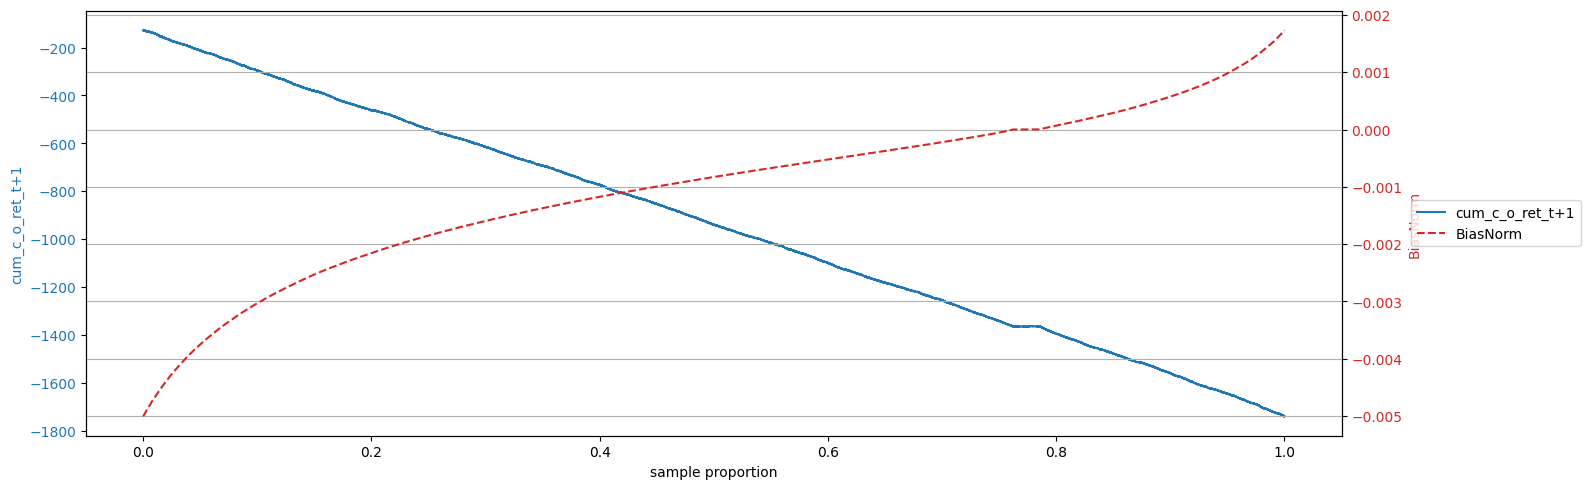

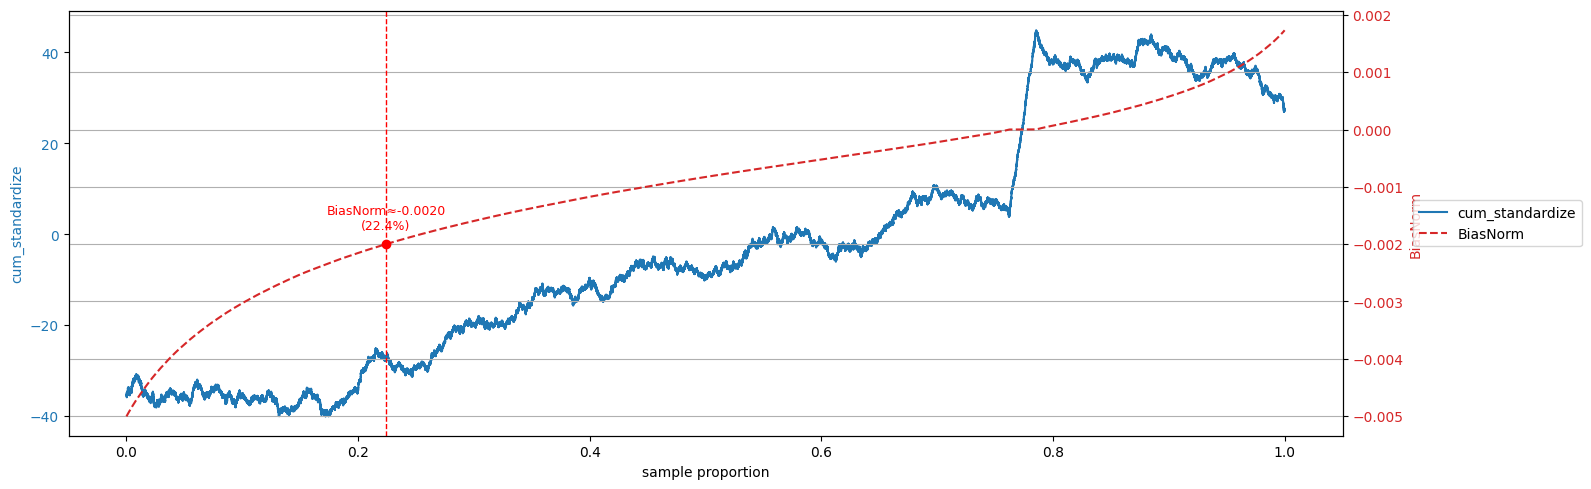

In [64]:
lower = bias_sorted_df["BiasNorm"].quantile(0.05)  # 下 % 分位數
upper = bias_sorted_df["BiasNorm"].quantile(0.95)  # 上 % 分位數
trimmed_df = bias_sorted_df[(bias_sorted_df["BiasNorm"] >= lower) & (bias_sorted_df["BiasNorm"] <= upper)]

sorted_plot(trimmed_df, "index", "cum_c_o_ret_t+1", max_ly = False, ry = "BiasNorm")
sorted_plot(trimmed_df, "index", "cum_standardize", max_ly = False, ry = "BiasNorm", point_ry = -0.002)

In [65]:
g21, g22, g23 = group(trimmed_df, "BiasNorm", point1 = 0.224, point2 = 0.762)

                      mean       std   count  missing
Group1 (0~20%)   -0.003073  0.000807  231663        0
Group2 (20~80%)  -0.000902  0.000545  556406        0
Group3 (80~100%)  0.000563  0.000472  246143        0 
   comparison       t-stat  p-value
0   g1 vs g2 -1186.715897      0.0
1   g2 vs g3 -1221.486313      0.0
2   g1 vs g3 -1885.843551      0.0


In [80]:
results2 = {}
group_names_2 = ["g21", "g22", "g23"]
groups2 = [g21, g22, g23]

for name, g in zip(group_names_2, groups2):
    X = sm.add_constant(g[["當沖佔交易量比例", "BiasNorm"]])
    Y = g["c_o_ret_t+1"]
    res = sm.OLS(Y, X).fit()
    results2[name] = res

print(results2["g22"].summary())

                            OLS Regression Results                            
Dep. Variable:            c_o_ret_t+1   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     797.5
Date:                Thu, 11 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:23:36   Log-Likelihood:             1.3853e+06
No. Observations:              556406   AIC:                        -2.771e+06
Df Residuals:                  556403   BIC:                        -2.770e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   6.73e-05      1.557      0.1

## regression

### macro

In [ ]:
"""concat 成 panel data"""

files = glob("test_data/*.csv")
dfs = []
for f in files:
    stock_id = f.split("\\")[-1].replace(".csv","")
    df = pd.read_csv(f, parse_dates = ["Date"])
    df["stock"] = stock_id
    df["c_o_spread"] = df["Close"] - df["Open"]         # 建立 Close - Open
    df["c_o_spread_t+1"] = df["c_o_spread"].shift(-1)
    dfs.append(df)

ratio_sorted_df = pd.concat(dfs, ignore_index = True)
ratio_sorted_df = ratio_sorted_df.sort_values(["Date","stock"])
ratio_sorted_df.dropna(inplace = True)

# 把 'stock' 移到第二個位置
cols = ratio_sorted_df.columns.tolist()
cols.remove("stock")
cols.insert(1, "stock")
ratio_sorted_df = ratio_sorted_df[cols]

In [93]:
"""fama macbeth regression"""

# cross sectional regression
rows = []
dates = []

vars_ = ["當沖佔交易量比例", "BiasNorm"]

for dt, g in ratio_sorted_df.groupby("Date"):
    Y = g["c_o_ret_t+1"]
    X = g[vars_]
    X = sm.add_constant(X)

    # 確保樣本不會太少
    if len(g) > X.shape[1] + 3:
        res = sm.OLS(Y, X).fit()
        rows.append(res.params.reindex(vars_).astype(float))
        dates.append(dt)

betas_df = pd.DataFrame(rows, index = pd.Index(dates, name = "Date")).sort_index()

# time series average
out = []
T = betas_df.shape[0]
X_time = sm.add_constant(np.ones(T))

# statistic
for col in betas_df.columns:
    series_t = betas_df[col].dropna()
    # 平均β
    beta_bar = series_t.mean()
    # NW-SE
    res_time = sm.OLS(series_t.values, X_time[:len(series_t)]).fit()
    cov = cov_hac(res_time)
    se_nw = np.sqrt(cov[0, 0])
    t_nw = beta_bar / se_nw
    out.append((col, beta_bar, se_nw, t_nw, len(series_t)))

res_table = pd.DataFrame(out, columns = ["var","beta_bar","SE_NW","t_NW","T"])
res_table

,var,beta_bar,SE_NW,t_NW,T
0,當沖佔交易量比例,-0.007673,0.000534,-14.362293,1379
1,BiasNorm,0.045269,0.016816,2.692021,1379


In [96]:
df = ratio_sorted_df[['Date','stock','c_o_ret_t+1','當沖佔交易量比例','BiasNorm']].copy()

# 1) 時間欄位轉成 datetime
df['Date'] = pd.to_datetime(df['Date'])

# 2) 先清 NaN
df = df.dropna(subset=['c_o_ret_t+1','當沖佔交易量比例','BiasNorm'])

# 3) （可選）winsorize 截尾，穩定估計
for col in ['c_o_ret_t+1','當沖佔交易量比例','BiasNorm']:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)

# 4) 設定 MultiIndex：entity 在前（stock），time 在後（Date）
df = df.set_index(['stock','Date']).sort_index()

y = df['c_o_ret_t+1']
X = df[['當沖佔交易量比例','BiasNorm']]

# （可選）加入常數項
X = X.copy()
X['const'] = 1.0

mod = FamaMacBeth(y, X)          # index 需是 (entity, time)
res = mod.fit(cov_type='kernel') # Newey–West 風格標準誤
print(res.summary)

                            FamaMacBeth Estimation Summary                           
Dep. Variable:                 c_o_ret_t+1   R-squared:                        0.0031
Estimator:                     FamaMacBeth   R-squared (Between):              0.2373
No. Observations:                  1149120   R-squared (Within):               0.0017
Date:                     Thu, Sep 11 2025   R-squared (Overall):              0.0031
Time:                             12:57:16   Log-likelihood                 2.902e+06
Cov. Estimator:    Fama-MacBeth Kernel Cov                                           
                                             F-statistic:                      1758.8
Entities:                              998   P-value                           0.0000
Avg Obs:                            1151.4   Distribution:               F(2,1149117)
Min Obs:                            2.0000                                           
Max Obs:                            1379.0   F-statist

In [ ]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     70.93
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.40e-42
Time:                        19:59:25   Log-Likelihood:                 236.94
No. Observations:                1347   AIC:                            -465.9
Df Residuals:                    1343   BIC:                            -445.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0542      0.009      5.761   

### industry

In [53]:
import requests
import pandas as pd

stock = "2330"  # 台積電
url = f"https://openapi.twse.com.tw/v1/exchangeReport/BWIBBU_d?stockNo={stock}"
data = requests.get(url, timeout=30, verify = False).json()

df = pd.DataFrame(data)
df["市值(元)"] = pd.to_numeric(df["市值(百萬元)"], errors="coerce") * 1_000_000

print(df[["日期", "證券代號", "證券名稱", "市值(元)"]])


c:\Users\ownme\anaconda3\envs\quant\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openapi.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


KeyError: '市值(百萬元)'

## random forest

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

### naive random forest

In [43]:
print(cols)

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '當日沖銷交易成交股數', '當日沖銷交易買進成交金額', '當日沖銷交易賣出成交金額', '當沖佔交易量比例', 'BiasNorm', 'MarginPurchaseBuy', 'MarginPurchaseCashRepayment', 'MarginPurchaseLimit', 'MarginPurchaseSell', 'MarginPurchaseTodayBalance', 'MarginPurchaseYesterdayBalance', 'Note', 'OffsetLoanAndShort', 'ShortSaleBuy', 'ShortSaleCashRepayment', 'ShortSaleLimit', 'ShortSaleSell', 'ShortSaleTodayBalance', 'ShortSaleYesterdayBalance', 'ForeignInvestmentRemainingShares', 'ForeignInvestmentShares', 'ForeignInvestmentRemainRatio', 'ForeignInvestmentSharesRatio', 'NumberOfSharesIssued', '1張以下', '1~5張', '5~10張', '10~15張', '15~20張', '20~30張', '30~40張', '40~50張', '50~100張', '100~200張', '200~400張', '400~600張', '600~800張', '800~1000張', '1000張以上', 'stock', 'c_o_ret', 'c_o_ret_t+1', 'demeaned_ret_t+1']


In [44]:
panel_df = get_c_o_ret(panel_df)
cols = [col for col in panel_df.columns if col not in ["Date", "Note", "stock", "c_o_ret", "c_o_ret_t+1", "demeaned_ret_t+1"]]
print(cols)

['Open', 'High', 'Low', 'Close', 'Volume', '當日沖銷交易成交股數', '當日沖銷交易買進成交金額', '當日沖銷交易賣出成交金額', '當沖佔交易量比例', 'BiasNorm', 'MarginPurchaseBuy', 'MarginPurchaseCashRepayment', 'MarginPurchaseLimit', 'MarginPurchaseSell', 'MarginPurchaseTodayBalance', 'MarginPurchaseYesterdayBalance', 'OffsetLoanAndShort', 'ShortSaleBuy', 'ShortSaleCashRepayment', 'ShortSaleLimit', 'ShortSaleSell', 'ShortSaleTodayBalance', 'ShortSaleYesterdayBalance', 'ForeignInvestmentRemainingShares', 'ForeignInvestmentShares', 'ForeignInvestmentRemainRatio', 'ForeignInvestmentSharesRatio', 'NumberOfSharesIssued', '1張以下', '1~5張', '5~10張', '10~15張', '15~20張', '20~30張', '30~40張', '40~50張', '50~100張', '100~200張', '200~400張', '400~600張', '600~800張', '800~1000張', '1000張以上']


<Axes: title={'center': 'Top 7 Feature Importances'}>

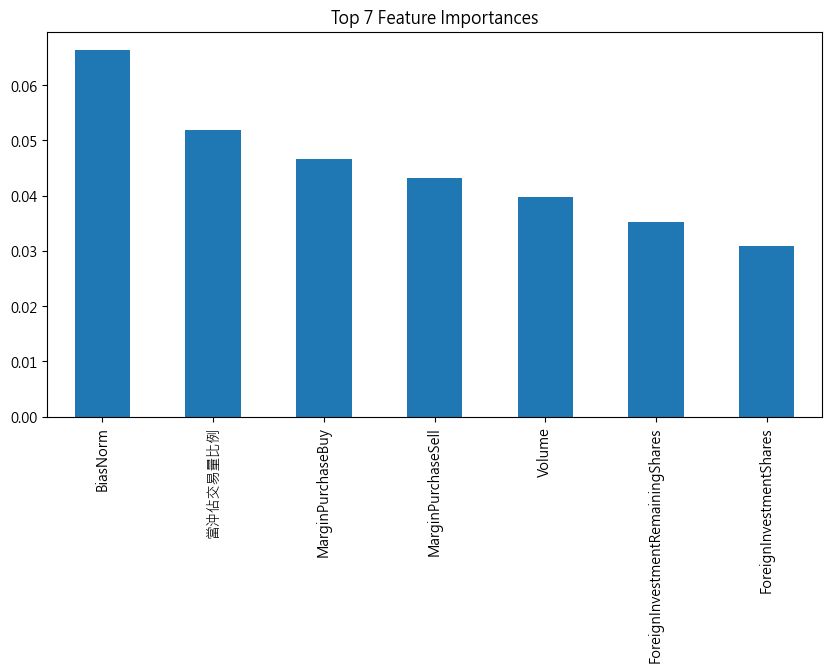

In [54]:

X = panel_df[cols]
Y = panel_df["demeaned_ret_t+1"]
train_df = pd.concat([X, Y], axis=1).dropna()

X_aligned = train_df.drop(columns=Y.name)
Y_aligned = train_df[Y.name]

model = RandomForestRegressor(random_state = 42)
model.fit(X_aligned, Y_aligned)

# 查看特徵重要性
importances = pd.Series(model.feature_importances_, index = X.columns)
top_n = 7
importances.sort_values(ascending=False).head(top_n).plot(kind="bar", figsize=(10, 5), title=f"Top {top_n} Feature Importances")

### target encoding random forest

In [17]:
def target_encode_timeseries(train: pd.DataFrame, valid: pd.DataFrame, col: str, target: str) -> pd.Series:
    """
    train: 訓練集 (只用過去資料)
    valid: 驗證集 (未來資料)
    col:   要做 target encoding 的欄位 (例如 'Industry')
    target: 標籤欄位 (例如 'target')
    """
    # get mean of train data
    mapping = train.groupby(col)[target].mean()

    # encode valid data by mean of train
    valid_encoded = valid[col].map(mapping)

    return valid_encoded

In [21]:
tscv = TimeSeriesSplit(n_splits = 5)
X = data[["Industry", "當沖佔交易量比例"]].copy()

KeyError: "['Industry'] not in index"